In [3]:
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
rd_state = 666

In [5]:
all_data = pd.read_csv("train.csv")
challenge_input_ori = pd.read_csv("test.csv")

all_input_ori = all_data.drop('Survived', axis=1)
all_labels = all_data['Survived'].copy()

# Extract a validation set
train_input_ori, validate_input_ori, train_labels, validate_labels = train_test_split(all_input_ori, all_labels, test_size=0.15, random_state=rd_state)

# Extract a testing set
train_input_ori, test_input_ori, train_labels, test_labels = train_test_split(train_input_ori, train_labels, test_size=0.18, random_state=rd_state)
#train_input_ori, test_input_ori, train_labels, test_labels = train_test_split(all_input_ori, all_labels, test_size=0.1, random_state=rd_state)

train_both_ori = train_input_ori.copy()
train_both_ori['Survived'] = train_labels

# Sanity check
print("All data:  %s" % (all_data.shape,))
print("All input: %s" % (all_input_ori.shape,))
print("Training:  %s" % (train_input_ori.shape,))
print("Test set:  %s" % (test_input_ori.shape,))
#print("Validate:  %s" % (validate_input_ori.shape,))

All data:  (891, 12)
All input: (891, 11)
Training:  (620, 11)
Test set:  (137, 11)


In [6]:
display(train_both_ori.head() )
display(train_both_ori.describe())
display(test_input_ori.describe())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
708,709,1,"Cleaver, Miss. Alice",female,22.0,0,0,113781,151.5500,NaN,S,1
181,182,2,"Pernot, Mr. Rene",male,NaN,0,0,SC/PARIS 2131,15.0500,NaN,C,0
424,425,3,"Rosblom, Mr. Viktor Richard",male,18.0,1,1,370129,20.2125,NaN,S,0
249,250,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.0000,NaN,S,0
738,739,3,"Ivanoff, Mr. Kanio",male,NaN,0,0,349201,7.8958,NaN,S,0


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,620.000000,620.000000,501.000000,620.000000,620.000000,620.000000,620.000000
mean,447.766129,2.329032,29.275948,0.503226,0.396774,32.208944,0.382258
std,258.892643,0.830436,14.679031,1.031799,0.845394,48.622145,0.486331
min,2.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,222.750000,2.000000,19.000000,0.000000,0.000000,7.925000,0.000000
50%,454.500000,3.000000,28.000000,0.000000,0.000000,14.500000,0.000000
75%,669.500000,3.000000,38.000000,1.000000,0.000000,30.500000,1.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,137.000000,137.000000,108.000000,137.000000,137.000000,137.000000
mean,439.423358,2.270073,29.939074,0.700730,0.423358,32.299542
std,267.229432,0.861801,14.207736,1.545225,0.810978,47.962008
min,1.000000,1.000000,0.920000,0.000000,0.000000,0.000000
25%,202.000000,1.000000,22.000000,0.000000,0.000000,7.895800
50%,422.000000,3.000000,28.000000,0.000000,0.000000,13.862500
75%,689.000000,3.000000,36.000000,1.000000,1.000000,34.375000
max,887.000000,3.000000,71.000000,8.000000,4.000000,263.000000


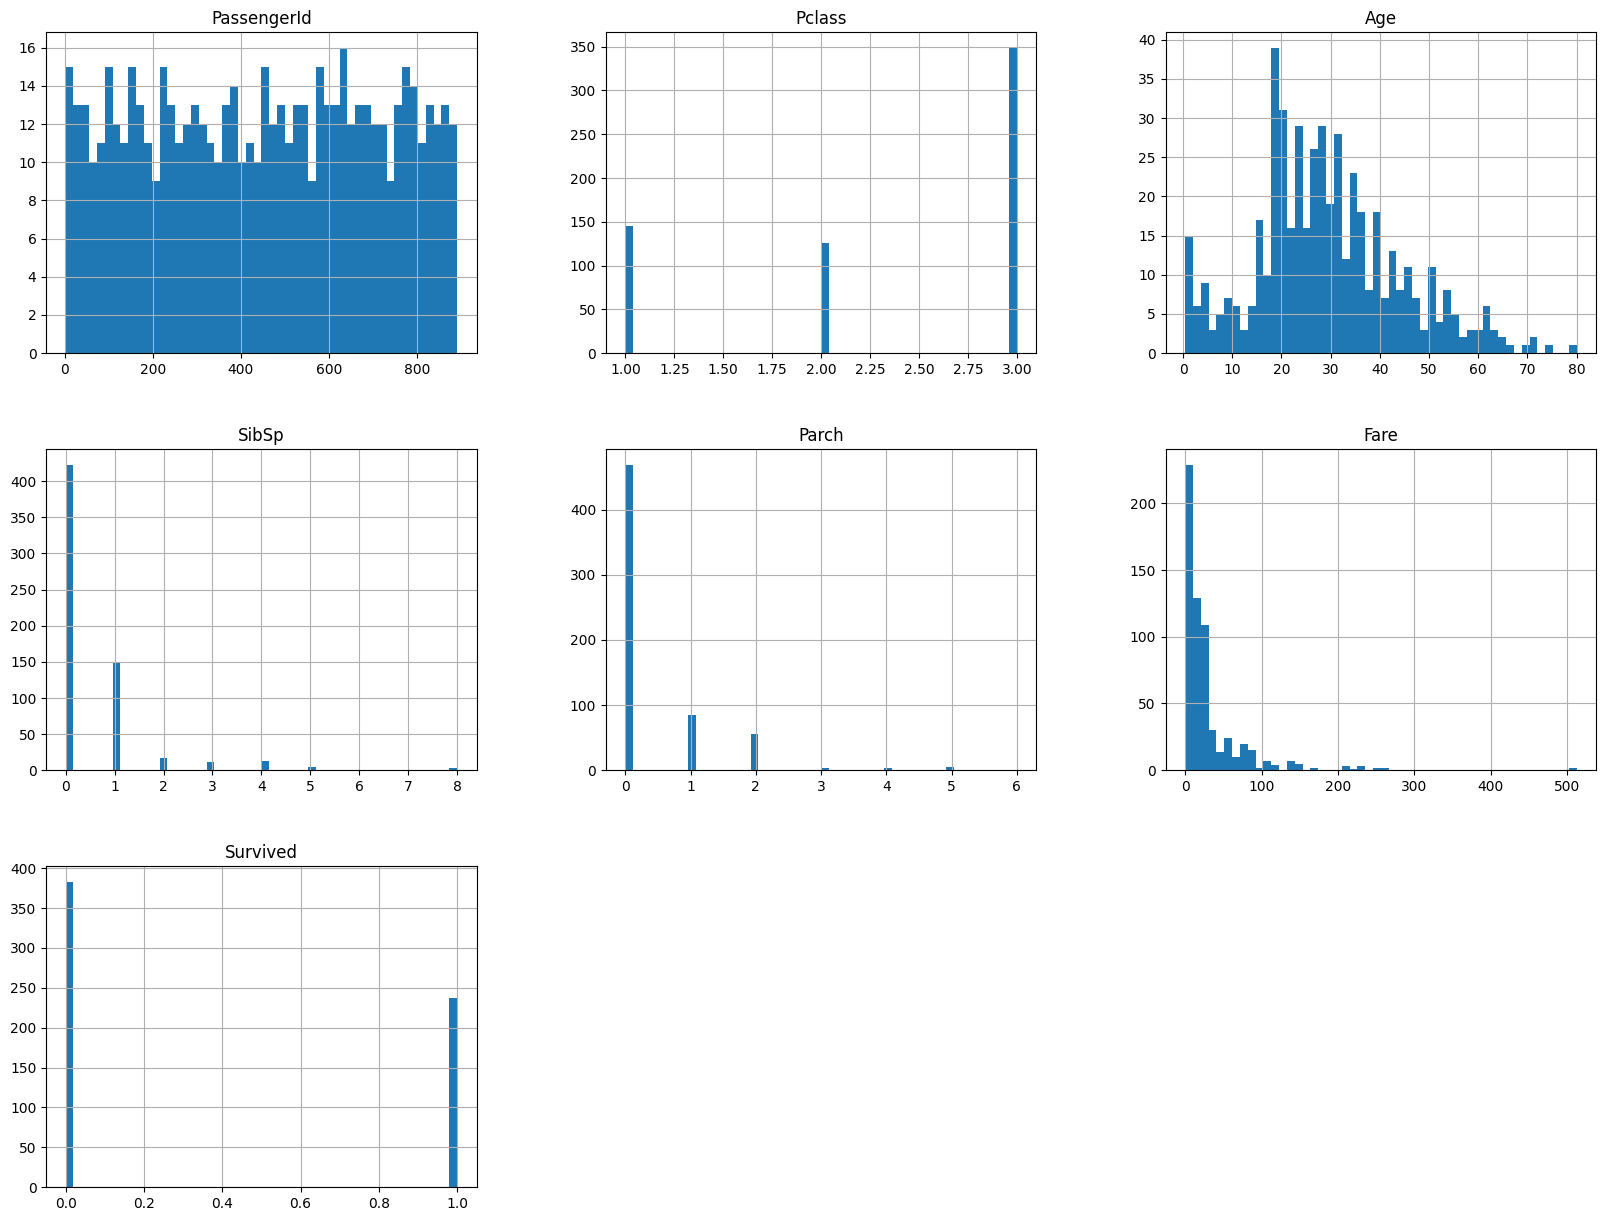

In [7]:
%matplotlib inline
train_both_ori.hist(bins=50, figsize=(20,15));

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

title_encoder = OneHotEncoder(
    categories=[["Capt", "Col", "Dr", "Lady", "Major", "Master", "Miss", 
                 "Mlle", "Mme", "Mr", "Mrs", "Ms", "Rev", "the Countess"]],
    handle_unknown='infrequent_if_exist',
    min_frequency=1,
)
embarked_encoder = OneHotEncoder(
    categories=[["S", "C", "Q"]],
    handle_unknown='infrequent_if_exist',
    min_frequency=1,
)

all_input_copy = all_input_ori.copy()
all_input_copy['Title'] = all_input_copy['Name'].str.split(', ', n=1, expand=True)[1].str.split('.', n=1, expand=True)[0]
title_encoder.fit_transform(all_input_copy[["Title"]])
embarked_encoder.fit_transform(all_input_copy[["Embarked"]])

def enrich_input(some_input_ori):
    some_input = some_input_ori.copy()
    
    # Sex as a number
    some_input["Male"] = (some_input["Sex"] == "male") * 1.0
    
    # Age buckets
    some_input['Age_2'] = 2*(some_input['Age']//2)
    some_input['Age_5'] = 5*(some_input['Age']//5)
    some_input['Age_10'] = 10*(some_input['Age']//10)
    
     # Family size
    some_input['FSize'] = some_input['Parch'] + some_input['SibSp']
    
    # Embarked as a number (Southampton (1) is the departure, then Cherbourg (2) then Queenstown (3))
    #some_input["Embarked_N"] = (some_input["Embarked"] == "Q") * 3.0 + \
    #                           (some_input["Embarked"] == "C") * 2.0 + \
    #                           (some_input["Embarked"] == "S") * 1.0
        
    some_input["Estimated_Age"] = 1.0 * (some_input["Age"] > 1) * (10*some_input["Age"]%10 == 5)
    
    # Extract and OneHotEncode title
    some_input['Title'] = some_input['Name'].str.split(', ', n=1, expand=True)[1].str.split('.', n=1, expand=True)[0]
    title_encoded = title_encoder.transform(some_input[['Title']]).toarray()
    some_input[title_encoder.get_feature_names_out()] = title_encoded

    # OneHotEncode Embarked
    embarked_encoded = embarked_encoder.transform(some_input[['Embarked']]).toarray()
    some_input[embarked_encoder.get_feature_names_out()] = embarked_encoded
    
    # Drop non-numerical data
    some_input = some_input.drop('Name', axis=1)
    some_input = some_input.drop('Sex', axis=1)
    some_input = some_input.drop('Ticket', axis=1)
    some_input = some_input.drop('Cabin', axis=1)
    some_input = some_input.drop('Embarked', axis=1)
    some_input = some_input.drop('Title', axis=1)
    
    return some_input

In [9]:
all_input = enrich_input(all_input_ori)
train_input = enrich_input(train_input_ori)
train_both = enrich_input(train_both_ori)
test_input = enrich_input(test_input_ori)
validate_input = enrich_input(validate_input_ori)
challenge_input = enrich_input(challenge_input_ori)

# Sanity check
print(" === Originals (unmodified)? ===")
print("All data:      %s" % (all_data.shape,))
print("All input:     %s" % (all_input_ori.shape,))
print("Training:      %s" % (train_input_ori.shape,))
print("Train both:    %s" % (train_both_ori.shape,))
print("Test set:      %s" % (test_input_ori.shape,))
print("Validate:      %s" % (validate_input_ori.shape,))
print("Challenge:     %s" % (challenge_input_ori.shape,))

print(" === Enriched ===")
print("All input:     %s" % (all_input.shape,))
print("Training:      %s" % (train_input.shape,))
print("Train both:    %s" % (train_both.shape,))
print("Test set:      %s" % (test_input.shape,))
print("Validate:      %s" % (validate_input.shape,))
print("Challenge:     %s" % (challenge_input.shape,))


 === Originals (unmodified)? ===
All data:      (891, 12)
All input:     (891, 11)
Training:      (620, 11)
Train both:    (620, 12)
Test set:      (137, 11)
Validate:      (134, 11)
Challenge:     (418, 11)
 === Enriched ===
All input:     (891, 29)
Training:      (620, 29)
Train both:    (620, 30)
Test set:      (137, 29)
Validate:      (134, 29)
Challenge:     (418, 29)


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived,Male,Age_2,Age_5,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_the Countess,Embarked_S,Embarked_C,Embarked_Q
PassengerId,1.000000,-0.033749,0.034954,-0.041560,0.007466,0.025245,0.016288,0.019815,0.033184,0.037153,...,0.050302,-0.012083,0.015652,-0.002493,-0.000585,-0.047744,0.048514,0.008710,-0.012770,-0.004472
Pclass,-0.033749,1.000000,-0.378168,0.104343,0.066867,-0.565885,-0.315930,0.132332,-0.378094,-0.374293,...,-0.091117,-0.064378,0.133126,-0.206692,-0.015938,-0.031954,-0.064378,0.112343,-0.268834,0.213790
Age,0.034954,-0.378168,1.000000,-0.318320,-0.169550,0.120855,-0.069573,0.106686,0.999428,0.995181,...,-0.022777,-0.016090,0.207118,0.196157,-0.003891,0.132901,0.011357,-0.008961,-0.028210,0.055973
SibSp,-0.041560,0.104343,-0.318320,1.000000,0.387463,0.103083,-0.058802,-0.134430,-0.317851,-0.321557,...,-0.027768,-0.019619,-0.263077,0.054492,-0.019619,-0.019793,-0.019619,0.083915,-0.046936,-0.066417
Parch,0.007466,0.066867,-0.169550,0.387463,1.000000,0.154156,0.047012,-0.250902,-0.172080,-0.177968,...,-0.026721,-0.018879,-0.321482,0.237904,-0.018879,-0.037851,-0.018879,0.049561,-0.000047,-0.078080
Fare,0.025245,-0.565885,0.120855,0.103083,0.154156,1.000000,0.243548,-0.186337,0.120552,0.123810,...,0.031842,0.030686,-0.178347,0.161557,-0.015892,-0.026937,0.044916,-0.204112,0.313623,-0.124962
Survived,0.016288,-0.315930,-0.069573,-0.058802,0.047012,0.243548,1.000000,-0.513888,-0.069083,-0.067060,...,0.072318,0.051095,-0.524146,0.340585,0.051095,-0.063389,0.051095,-0.161837,0.182125,-0.005982
Male,0.019815,0.132332,0.106686,-0.134430,-0.250902,-0.186337,-0.513888,1.000000,0.106563,0.106958,...,-0.075639,-0.053441,0.873372,-0.544341,-0.053441,0.060606,-0.053441,0.138465,-0.112539,-0.055898
Age_2,0.033184,-0.378094,0.999428,-0.317851,-0.172080,0.120552,-0.069083,0.106563,1.000000,0.994489,...,-0.020719,-0.014636,0.206904,0.194142,-0.002466,0.132385,0.009705,-0.009948,-0.027533,0.056486
Age_5,0.037153,-0.374293,0.995181,-0.321557,-0.177968,0.123810,-0.067060,0.106958,0.994489,1.000000,...,-0.030887,-0.021818,0.206252,0.190837,-0.006762,0.129904,0.008295,-0.013348,-0.025806,0.061080


<Axes: xlabel='Age', ylabel='Fare'>

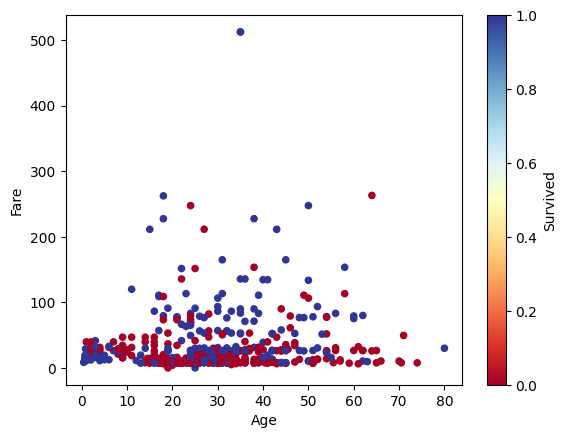

In [10]:
display(train_both.corr(numeric_only=True))

# colormaps: https://matplotlib.org/stable/gallery/color/colormap_reference.html
train_both.plot.scatter("Age", "Fare", c="Survived", colormap="RdYlBu")

#df = pd.crosstab(pd.cut(train_both['Pclass'], 3), train_both['Male'])

#df = train_both[['Pclass','Male','Survived', 'PassengerId']] \
#          .groupby(['Pclass','Male','Survived']) \
#          .count().reset_index() \
#          .pivot(columns='Survived', index=['Pclass','Male'])
#display(df)
#df.plot.bar(stacked=True, color=['r', 'b'])

# Doesn't quite work
#df = train_both[['Pclass','Male','PassengerId']]
#display(df)
#df.plot.hist(by=['Pclass','Male'], stacked=True, color=['r','b'])

#pd.plotting.scatter_matrix(train_both, figsize=(12, 8))

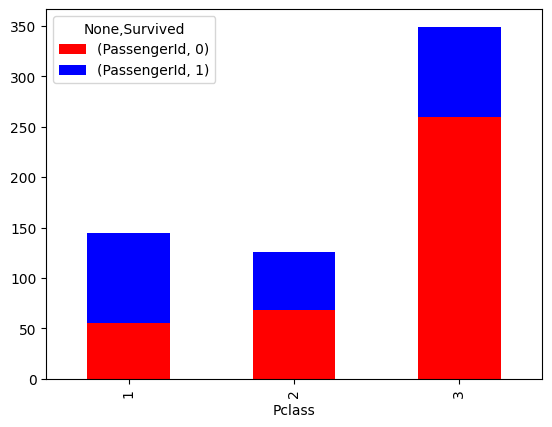

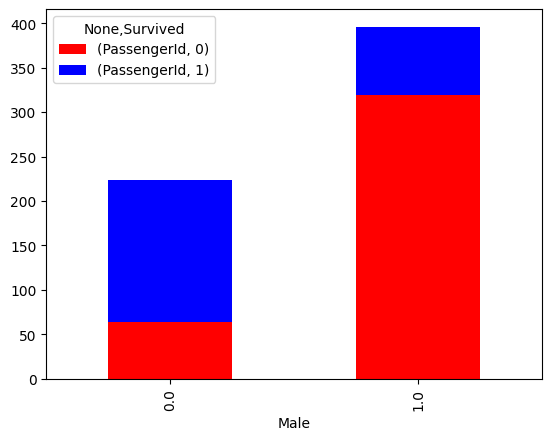

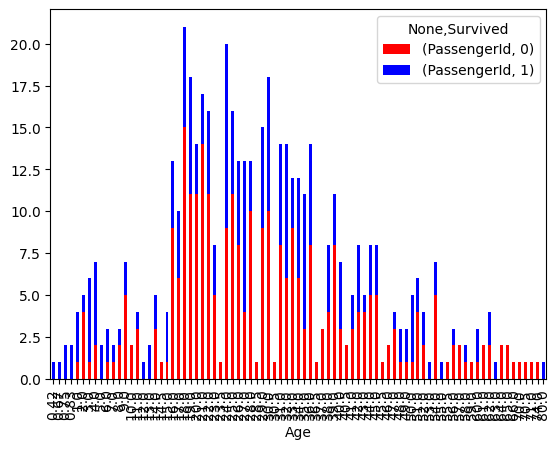

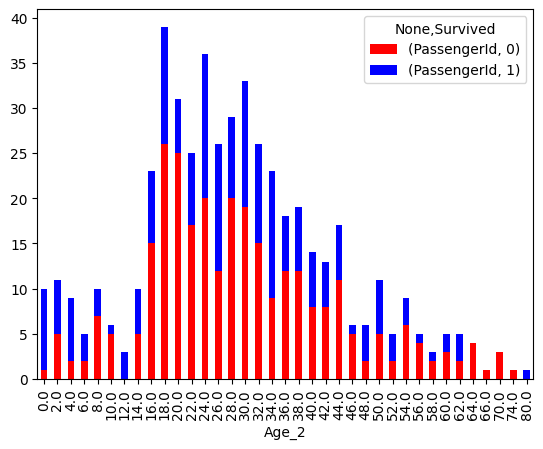

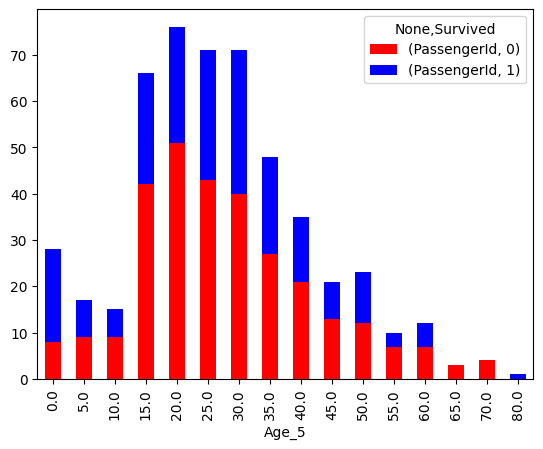

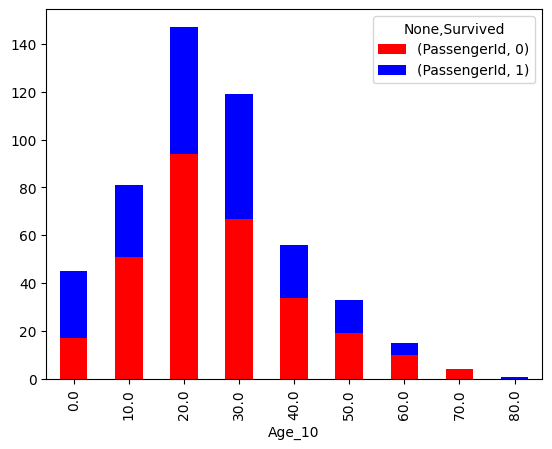

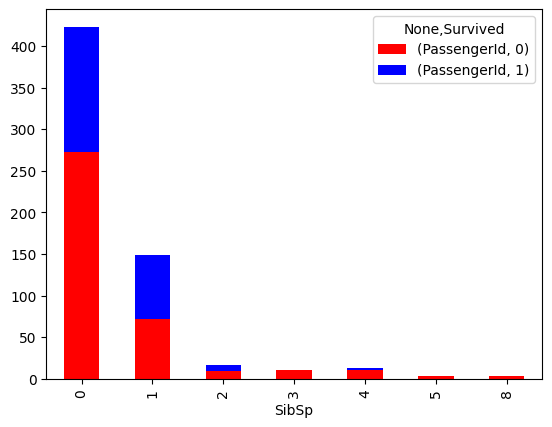

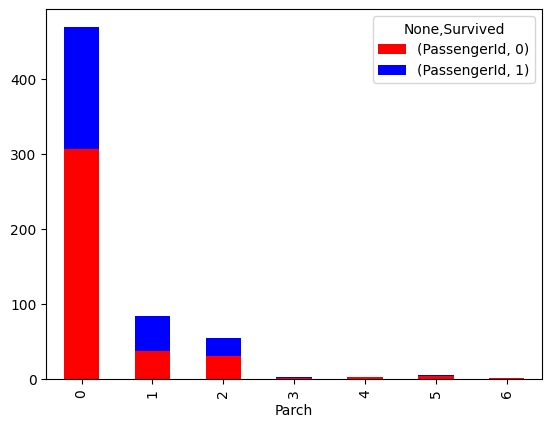

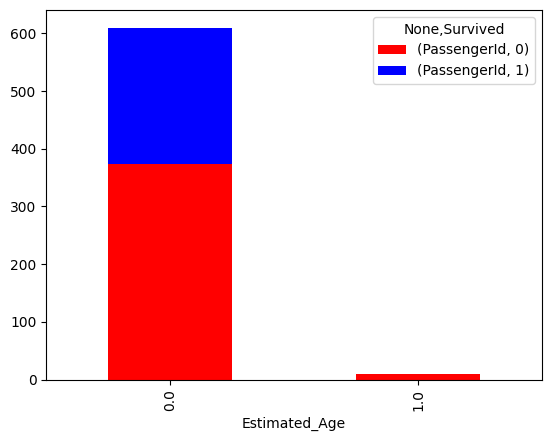

In [11]:
def hist_by(column):
    df = train_both[[column, 'Survived', 'PassengerId']] \
              .groupby([column, 'Survived']) \
              .count().reset_index() \
              .pivot(columns='Survived', index=[column])
    df.plot.bar(stacked=True, color=['r', 'b'])

hist_by('Pclass')
hist_by('Male')
hist_by('Age')
hist_by('Age_2')
hist_by('Age_5')
hist_by('Age_10')
hist_by('SibSp')
hist_by('Parch')
hist_by('Estimated_Age')

# TODO: hist_by one hot encoded stuff
#hist_by('Title')
#hist_by('Embarked')


In [12]:
display(set(train_input["PassengerId"]).intersection(set(test_input["PassengerId"])))
display(set(train_input["PassengerId"]).intersection(set(validate_input["PassengerId"])))
display(set(test_input["PassengerId"]).intersection(set(validate_input["PassengerId"])))
train_input

set()

set()

set()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Male,Age_2,Age_5,Age_10,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_the Countess,Embarked_S,Embarked_C,Embarked_Q
708,709,1,22.0,0,0,151.5500,0.0,22.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
181,182,2,NaN,0,0,15.0500,1.0,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
424,425,3,18.0,1,1,20.2125,1.0,18.0,15.0,10.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
249,250,2,54.0,1,0,26.0000,1.0,54.0,50.0,50.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
738,739,3,NaN,0,0,7.8958,1.0,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,718,2,27.0,0,0,10.5000,0.0,26.0,25.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
568,569,3,NaN,0,0,7.2292,1.0,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
161,162,2,40.0,0,0,15.7500,0.0,40.0,40.0,40.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
702,703,3,18.0,0,1,14.4542,0.0,18.0,15.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, DotProduct, Exponentiation, ExpSineSquared, Matern, RationalQuadratic, RBF
from sklearn.impute import SimpleImputer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import itertools

rd = 42


all_classifiers = dict()

# 0.76: clf = KNeighborsClassifier(3)
# 0.77: clf = SVC(kernel="linear", C=0.025, random_state=rd)
# 0.74: clf = SVC(gamma=2, C=1, random_state=rd)
# 0.74: clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=rd)
# 0.79: clf = RandomForestClassifier(max_depth=3, n_estimators=3, max_features=1, random_state=rd)
# 0.78: clf = RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, random_state=rd)
# 0.83: clf = MLPClassifier(alpha=0.1, max_iter=1000, random_state=rd)
# 0.77: clf = GaussianProcessClassifier(1.0 * RBF(1.0), random_state=rd)
# 0.80: clf = DecisionTreeClassifier(max_depth=3, random_state=rd)
# 0.75: clf = AdaBoostClassifier(random_state=rd)
# 0.75: clf = GaussianNB()
# 0.76: clf = QuadraticDiscriminantAnalysis()

for k in range(1, 20):
    all_classifiers["k-neighbors, k=%s" % k] = KNeighborsClassifier(k)

for k in ["linear", "poly", "rbf", "sigmoid"]: # linear, poly, rbf, sigmoid, precomputed
    for g in ["scale", "auto", 1, 2, 3, 5]:
        for c in [0.025, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
            all_classifiers["svc %s, g=%s, c=%s" % (k, g, c)] = SVC(kernel=k, gamma=g, C=c, random_state=rd)

for d in range(1, 10):
    for e in range(1, 10):
        for m in range(1, 20):
            all_classifiers["random-forest, depth=%s, est=%s, max_features=%s" % (d, e, m)] = \
              RandomForestClassifier(max_depth=d, n_estimators=e, max_features=m, random_state=rd)

for s in range(1, 10):
    for act in ["relu"]:               # identity, relu, logistic, tanh, relu
        for solver in ["lbfgs"]:       # lbfgs (better for small datasets), sgd or adam
            for rate in ["adaptive"]:  # constant, invscaling or adaptive
                for a in [0.1, 0.5, 1]:
                    all_classifiers["mlp, sz=%s, act=%s, solver=%s, learn_rate=%s, alpha=%s" % (s, act, solver, rate, a)] = \
                      MLPClassifier(
                       hidden_layer_sizes=(s,),
                       activation=act, 
                       solver=solver,
                       learning_rate=rate, 
                       alpha=a,
                       max_iter=2000,
                       random_state=rd
                      )
                    all_classifiers["mlp2, sz=%s, act=%s, solver=%s, learn_rate=%s, alpha=%s" % ((s, s), act, solver, rate, a)] = \
                      MLPClassifier(
                       hidden_layer_sizes=(s,s),
                       activation=act, 
                       solver=solver,
                       learning_rate=rate, 
                       alpha=a,
                       max_iter=2000,
                       random_state=rd
                      )

for k in [ConstantKernel(), DotProduct(), Exponentiation(RBF(), 2), 1.0 * RBF(1.0), Matern(), RationalQuadratic(alpha_bounds=(1e-5, 1e10))]:
    all_classifiers["gaussian-process, %s" % k] = GaussianProcessClassifier(kernel=k, random_state=rd)

for d in range(1, 10):
    all_classifiers["decision-tree, d=%s" % d] = DecisionTreeClassifier(max_depth=d, random_state=rd)
    
for d in range(1, 3):
    all_classifiers["ada-boost, d = %s" % d] = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=d),
                                                                  random_state=rd)
    
all_classifiers["gaussian-nb"] = GaussianNB()
#all_classifiers["QDA"] = QuadraticDiscriminantAnalysis()

scl = StandardScaler()
imp = SimpleImputer(strategy='mean')

max_score = 0
max_description = None
scored_classifiers = []
for description, clf in all_classifiers.items():
    try:
        pip = make_pipeline(scl, imp, clf)
        
        #pip.fit(train_input, train_labels)

        #test_score = pip.score(test_input, test_labels)        
        #validate_score = pip.score(validate_input, validate_labels)
        #score = min(test_score, validate_score)
        #print("%s: %s (%s, %s)" % (description, score, test_score, validate_score))
        
        scores = cross_val_score(pip, all_input, all_labels,
                                 scoring=make_scorer(balanced_accuracy_score),
                                 cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10,
                                                            random_state=rd))
        score=scores.mean()
        print("%s: %s (std: %s)" % (description, scores.mean(), scores.std()))
        
        scored_classifiers.append((score, description, pip))
        
        if score > max_score:
            max_score = score
            max_description = description
    
            # The model did good, train it on all the data we have
            pip.fit(all_input, all_labels)
        
            challenge_output = pip.predict(challenge_input)
            challenge_result = challenge_input.copy()
            challenge_result["Survived"] = challenge_output
            challenge_result.to_csv("cpitrat_result.csv", columns=["PassengerId", "Survived"], index=False)
    except e:
        print("Failed on '%s': %s" % (description, e))
    
print("Max score for '%s': %s" % (max_description, max_score))

scored_classifiers.sort(key=lambda x: x[0], reverse=True)

k-neighbors, k=1: 0.7340300908242086 (std: 0.04210970911508528)
k-neighbors, k=2: 0.723780041309453 (std: 0.04364962607993771)
k-neighbors, k=3: 0.7815827886710239 (std: 0.03742930381406342)
k-neighbors, k=4: 0.782612214582803 (std: 0.037111702748355006)
k-neighbors, k=5: 0.7925565317035905 (std: 0.035109772699170705)
k-neighbors, k=6: 0.7920984353337295 (std: 0.03914573526547602)
k-neighbors, k=7: 0.8040214752567694 (std: 0.03566807353571927)
k-neighbors, k=8: 0.800457176810118 (std: 0.03868232899432884)
k-neighbors, k=9: 0.8050256769374416 (std: 0.03549774202192288)
k-neighbors, k=10: 0.8019495373907138 (std: 0.03789812681871331)
k-neighbors, k=11: 0.806056857086269 (std: 0.03712894114142647)
k-neighbors, k=12: 0.8010525988173046 (std: 0.03865790213775094)
k-neighbors, k=13: 0.8027604476133888 (std: 0.03796693345055012)
k-neighbors, k=14: 0.8014933084344849 (std: 0.03848811799381572)
k-neighbors, k=15: 0.8019538663950427 (std: 0.03734916386675292)
k-neighbors, k=16: 0.801286435786435

/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


mlp2, sz=(4, 4), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.1: 0.7824000650765356 (std: 0.04198467731299706)
mlp, sz=4, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.5: 0.789325778796367 (std: 0.04224019022253843)
mlp2, sz=(4, 4), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.5: 0.7834731064142829 (std: 0.04157412660970896)
mlp, sz=4, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=1: 0.7890990153637213 (std: 0.04075120223508782)
mlp2, sz=(4, 4), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=1: 0.7872583679936621 (std: 0.04446208393061075)
mlp, sz=5, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.1: 0.780247870865518 (std: 0.044750487932266464)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp2, sz=(5, 5), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.1: 0.7677217553688144 (std: 0.04207573191673823)
mlp, sz=5, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.5: 0.783427793339558 (std: 0.04246280139485071)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp2, sz=(5, 5), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.5: 0.7762580709051297 (std: 0.04259051783580874)
mlp, sz=5, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=1: 0.7867112299465241 (std: 0.03963047335007821)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


mlp2, sz=(5, 5), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=1: 0.7803332201567497 (std: 0.04201162960591978)
mlp, sz=6, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.1: 0.7796883824236767 (std: 0.038582640630275215)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp2, sz=(6, 6), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.1: 0.7743507059389413 (std: 0.03989532665942169)
mlp, sz=6, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.5: 0.788135161135161 (std: 0.03823726486691435)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp2, sz=(6, 6), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.5: 0.7816029906912259 (std: 0.03964435477729988)
mlp, sz=6, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=1: 0.7909492968904733 (std: 0.0382432092006011)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp2, sz=(6, 6), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=1: 0.7865623461505813 (std: 0.03872440215205039)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp, sz=7, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.1: 0.7775655999773644 (std: 0.04139423294991826)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp2, sz=(7, 7), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.1: 0.7664826415414648 (std: 0.0443311309426075)
mlp, sz=7, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.5: 0.7819827264239028 (std: 0.043885573245949966)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp2, sz=(7, 7), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.5: 0.7713092408680643 (std: 0.04283674878469374)
mlp, sz=7, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=1: 0.7873400390459213 (std: 0.04316357123250724)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp2, sz=(7, 7), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=1: 0.7781258099199277 (std: 0.040198045326041563)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp, sz=8, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.1: 0.7749794301559007 (std: 0.04359272224569252)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp2, sz=(8, 8), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.1: 0.7618596893302775 (std: 0.04363489268117121)
mlp, sz=8, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.5: 0.7836037546331666 (std: 0.0405846181137151)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp2, sz=(8, 8), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.5: 0.7742740146563678 (std: 0.042987046250511564)
mlp, sz=8, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=1: 0.787494737288855 (std: 0.04097079321668482)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp2, sz=(8, 8), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=1: 0.7839423931188637 (std: 0.040591707751684976)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp, sz=9, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.1: 0.7726518546812664 (std: 0.0419931516012431)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp2, sz=(9, 9), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.1: 0.7575777664601193 (std: 0.04550187505867743)
mlp, sz=9, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.5: 0.7803870356223297 (std: 0.03682781265070424)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp2, sz=(9, 9), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=0.5: 0.7698000169764876 (std: 0.04441370338620112)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


mlp, sz=9, act=relu, solver=lbfgs, learn_rate=adaptive, alpha=1: 0.7817197181903065 (std: 0.04141438225003346)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converg

mlp2, sz=(9, 9), act=relu, solver=lbfgs, learn_rate=adaptive, alpha=1: 0.7807612398494751 (std: 0.04077524125324513)
gaussian-process, 1**2: 0.5 (std: 0.0)
gaussian-process, DotProduct(sigma_0=1): 0.8071131341425459 (std: 0.036698251373603864)
gaussian-process, RBF(length_scale=1) ** 2: 0.8075652463005405 (std: 0.03623976668942263)
gaussian-process, 1**2 * RBF(length_scale=1): 0.8098225532637298 (std: 0.03602415218087458)
gaussian-process, Matern(length_scale=1, nu=1.5): 0.8069074215544805 (std: 0.03580057950247005)


/home/cpitrat/python-venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpc.py:477: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


gaussian-process, RationalQuadratic(alpha=1, length_scale=1): 0.8075652463005405 (std: 0.03623976668942263)
decision-tree, d=%s: 0.7691734997029114 (std: 0.04219361234442193)
ada-boost: 0.7645523017287723 (std: 0.0399524770896972)
gaussian-nb: 0.5178633958633958 (std: 0.03055884975478162)
Max score for 'svc rbf, g=auto, c=1.0': 0.8127734346263759


In [17]:
# Voting of the N best classifiers

N = 10

estimators = []
for s, d, c in scored_classifiers[:N]:
    print("%s: %s" % (s, d))
    estimators.append((d, c))
    
v = VotingClassifier(estimators)

scores = cross_val_score(v, all_input, all_labels,
                         scoring=make_scorer(balanced_accuracy_score),
                         cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10,
                                                    random_state=rd))

print("Voting score: %s (std: %s)" % (scores.mean(), scores.std()))
    
v.fit(all_input, all_labels)

challenge_output = v.predict(challenge_input)
challenge_result = challenge_input.copy()
challenge_result["Survived"] = challenge_output
challenge_result.to_csv("cpitrat_result.csv", columns=["PassengerId", "Survived"], index=False)

0.8110441105735222: random-forest, depth=5, est=9, max_features=9
0.8104218798630562: random-forest, depth=5, est=8, max_features=9
0.8099259966612906: random-forest, depth=4, est=9, max_features=17
0.8098225532637298: gaussian-process, 1**2 * RBF(length_scale=1)
0.8097266078148431: random-forest, depth=4, est=9, max_features=13
0.8093004555357497: random-forest, depth=6, est=9, max_features=14
0.8091197408256231: random-forest, depth=5, est=7, max_features=9
0.8090331607390431: random-forest, depth=5, est=8, max_features=19
0.8088576097105508: random-forest, depth=7, est=9, max_features=8
0.8088485131426307: random-forest, depth=5, est=8, max_features=13
Voting score: 0.8118370823076704 (std: 0.03882764219382639)


In [19]:
# Voting of the classifiers above a certain score, with max N per type

from collections import defaultdict

N = 3

estimators = []
types = defaultdict(int)
for s, n, c in scored_classifiers:
    t = n.split(',')[0]
    if types[t] < N:
        types[t] += 1
        estimators.append((n, c))
        print("%s: %s: %s" % (s, t, n))
    if s < 0.8095:
        break

v = VotingClassifier(estimators)

scores = cross_val_score(v, all_input, all_labels,
                         scoring=make_scorer(balanced_accuracy_score),
                         cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10,
                                                    random_state=rd))

print("Voting score: %s (std: %s)" % (scores.mean(), scores.std()))
    
v.fit(all_input, all_labels)

challenge_output = v.predict(challenge_input)
challenge_result = challenge_input.copy()
challenge_result["Survived"] = challenge_output
challenge_result.to_csv("cpitrat_result.csv", columns=["PassengerId", "Survived"], index=False)

0.8110441105735222: random-forest: random-forest, depth=5, est=9, max_features=9
0.8104218798630562: random-forest: random-forest, depth=5, est=8, max_features=9
0.8099259966612906: random-forest: random-forest, depth=4, est=9, max_features=17
0.8098225532637298: gaussian-process: gaussian-process, 1**2 * RBF(length_scale=1)
Voting score: 0.8113635231870525 (std: 0.037995960841398536)
